# 优化器的基础：梯度下降

梯度是函数值增长最快的方向向量。在深度学习中，我们通过让参数w沿梯度反方向更新来最小化损失函数L(w)。

由于神经网络是多层复合函数，我们需要用链式法则计算L(w)对各参数的偏导数，获得梯度后即可反向优化参数，逐步降低损失值。


## SGD 随机梯度下降

传统梯度下降需要全量数据计算梯度，计算开销大。SGD通过每次随机选取单个样本或小批量(mini-batch)来近似计算梯度：

$$
\theta_{t+1} = \theta_{t} - \gamma g_t
$$

其中：
- θ：模型参数
- γ：学习率  
- g：当前批次的梯度估计

SGD在保持优化效果的同时大幅降低了计算量，使神经网络能处理大规模数据。

SGD 为什么有效？

SGD 的核心在于用**小批量数据的梯度**（甚至是单样本梯度）来**估计全量数据的真实梯度**。其有效性基于以下原理：  

(1) 无偏梯度估计

假设训练数据独立同分布（i.i.d.），小批量梯度是**全量梯度的无偏估计**：

$$
\mathbb{E}_{batch}[\nabla L_{batch}(\theta)] = \nabla L(\theta)
$$

即**长期来看，随机梯度的期望等于真实梯度**，因此优化方向整体上是正确的。  

(2) 引入噪声帮助逃离局部极小值

SGD 的随机性会引入梯度噪声，这反而可能帮助模型：
- 逃离**局部极小值**（但无法保证逃出鞍点，需结合动量或自适应优化器）。  
- 在**平坦区域**（梯度接近零）时，噪声可能提供扰动，帮助继续优化。  

(3) 计算效率高
- 全量梯度下降（Batch GD）每步计算复杂度为 $O(N)$（$N$ 是数据量）。  
- SGD 每步复杂度为 $O(B)$（$B$ 是 batch size），通常 $B \ll N$，计算更快。  

可以联想用蒙特卡洛（monte carlo）算法来估计全梯度计算


## 动量 Momentum

使用SGD算法时，模型可能因梯度变化过大而震荡，导致收敛过慢。引入动量可抵消剧烈变化的梯度分量，通过叠加历史梯度，平滑纵向变化，从而加速收敛。

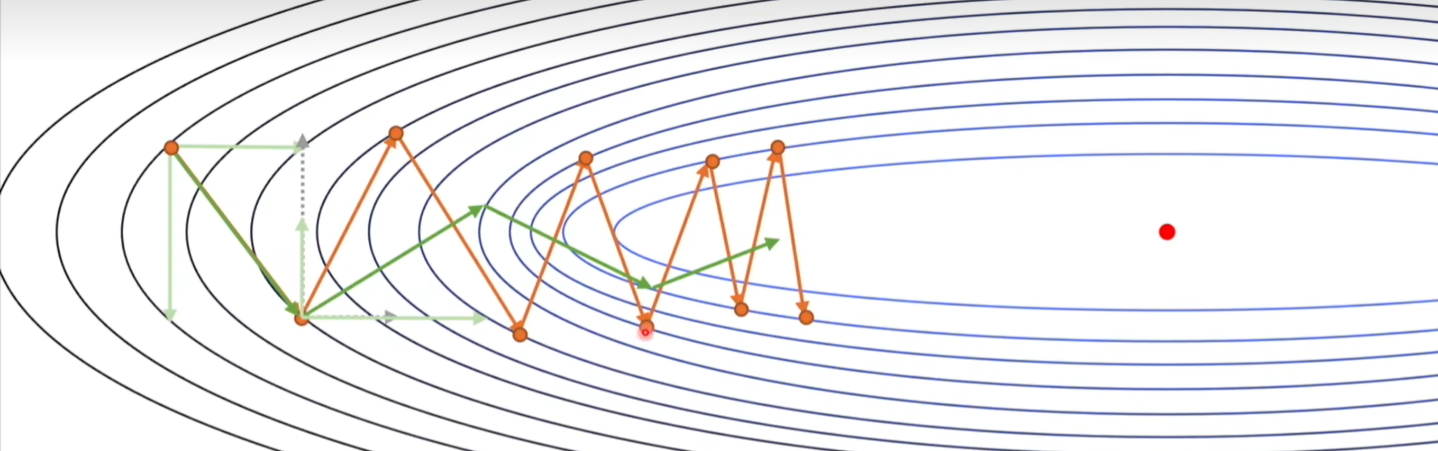

- **核心思想**：引入历史梯度的指数加权平均，减少震荡。
- **公式**：
$$
m_t = \beta m_{t-1} + (1-\beta)\nabla L(\theta_t)
$$
$$
\theta_{t+1} = \theta_t - \gamma m_t
$$

**特点**：
  - 动量累积使优化方向更稳定，加速收敛。
  - 超参数 $\beta$（通常0.9）控制历史梯度权重。

梯度的动量可以理解为一种“记忆”机制，它帮助优化算法在迭代过程中保持一定的“惯性”，从而更平稳地收敛。

在大多数情况下，将动量项初始化为零是最简单且最常用的方法。这种方法简单直观，且在大多数优化任务中都能取得良好的效果。如果需要更快速地积累动量，可以尝试将动量项初始化为小的随机值或当前梯度的缩放值，但需要注意初始值的大小，以避免对算法稳定性产生负面影响。

在实际应用中，通常建议从零初始化开始，如果发现算法收敛速度较慢，再尝试其他初始化方法进行调整。

## Nesterov's Accelerated Gradient (NAG)

动量的原理，可以想象成一个小球从山坡上滚下来。随着动量的累积，小球会越滚越快。然而，这种动量也可能导致问题：在优化过程中，我们的目标是让小球停在谷底，但由于动量的存在，小球可能会在到达谷底时冲过头，并在最后的收敛阶段不停震荡，从而浪费很多时间。

为了解决这个问题，NAG（Nesterov's Accelerated Gradient）算法被提出。它的核心思想是让优化器在梯度更新之前“向前看一步”，提前预知未来的情况，从而对当前的梯度进行调整。

- **核心思想**：在动量基础上“向前看一步”，提前调整梯度。
- **公式**：
$$
m_t = \beta m_{t-1} + \nabla L(\theta_t - \beta \gamma m_{t-1})
$$
$$
\theta_{t+1} = \theta_t - \gamma m_t
$$

是根据当前梯度方向向前走一步之后再计算出来的梯度。通过这种方式，在接近最优解时，Nesterov优化器比标准动量SGD算法有更快的收敛速度。因为这种“前瞻性”的操作能帮助优化器避免走得太远，就像是提前刹车，所以在接近最优解时更加稳定。

- **特点**：
  - 在接近最优解时更稳定，减少超调（overshooting）。
  - PyTorch实现通过数学等效简化计算。

## AdaGrad (自适应学习率)

学习率决定了优化过程中的步长。如果学习率设置过大，参数可能会在最优点附近震荡；而如果设置过小，模型的收敛速度会过慢。因此，通常会选择让学习率逐步减小的策略，例如余弦退火算法或StepLR策略等。

然而，即使采用了学习率衰减策略，还有一个问题尚未解决：不同参数可能需要不同的学习率。那么，是否可以让模型自动调整学习率呢？AdaGrad方法正是为了解决这一问题而提出的。

AdaGrad的核心思想是根据每个参数的历史梯度动态调整学习率。对于之前震荡较大的参数，学习率会自动减小；而对于更新速率较慢的参数，学习率会增大。这样可以使模型更快地收敛。

- **核心思想**：自适应调整学习率，对频繁更新的参数减小步长。
- **公式**：
$$
G_t = G_{t-1} + \nabla L(\theta_t)^2
$$
$$
\theta_{t+1} = \theta_t - \frac{\gamma}{\sqrt{G_t + \epsilon}} \nabla L(\theta_t)
$$

$G_t$ 代表着历史中所有梯度的平方和， $\epsilon$ 是防止除 0 的极小量。

- **特点**：
  - 适合稀疏数据（如NLP任务）。
  - 学习率单调下降，后期可能过小导致训练停滞。

## RMSProp（Root Mean Square Propagation）


AdaGrad算法存在一个明显的问题：它会累积所有历史梯度的平方，导致分母 $G_t$ 越来越大。这使得学习率逐渐减小，模型的收敛速度也会变慢。

为了解决这一问题，RMSProp（Root Mean Square Propagation）算法引入了指数加权移动平均法，以减小早期梯度对当前学习率的影响


- **核心思想**：改进AdaGrad，用指数加权平均替代累积平方梯度。
- **公式**：
$$
G_t = \beta G_{t-1} + (1-\beta)\nabla L(\theta_t)^2
$$
$$
\theta_{t+1} = \theta_t - \frac{\gamma}{\sqrt{G_t + \epsilon}} \nabla L(\theta_t)
$$
- **特点**：
  - 解决AdaGrad学习率衰减过快的问题。
  - 超参数 $\beta$（通常0.9）控制历史梯度权重。


## Adam

SGD算法主要关注梯度优化，而RMSProp方法则专注于优化学习率。那么，是否可以将这两种方法结合起来呢？将SGD Momentum与RMSProp结合起来的方法就是Adam算法。

一阶矩和二阶矩分别代表了梯度的指数加权移动平均值和梯度平方的指数加权移动平均值。

- **核心思想**：结合动量（一阶矩）和RMSProp（二阶矩）。
- **公式**：
$$
m_t = \beta_1 m_{t-1} + (1-\beta_1)\nabla L(\theta_t)
$$
$$
v_t = \beta_2 v_{t-1} + (1-\beta_2)\nabla L(\theta_t)^2
$$
$$
\hat{m}_t = \frac{m_t}{1-\beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1-\beta_2^t}
$$
$$
\theta_{t+1} = \theta_t - \frac{\gamma}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t
$$

- **特点**：
  - 自适应学习率 + 动量，适合大多数任务。
  - 默认超参数 $\beta_1=0.9, \beta_2=0.999$。



## AdamW

人们发现，尽管Adam在理论上具有优势，但在某些情况下，其表现并不如SGD Momentum，尤其是在模型泛化性能方面。

我们知道，L2范数（也称为权重衰减）有助于提高模型的泛化性能。然而，AdamW的作者发现，Adam算法削弱了L2范数的作用，导致使用Adam训练的模型泛化能力较弱。具体来说，在Adam中，权重衰减的梯度直接加在更新公式中，这使得权重衰减的梯度也会被除以分母。当梯度的平方和累积过大时，权重衰减的作用会被显著削弱。

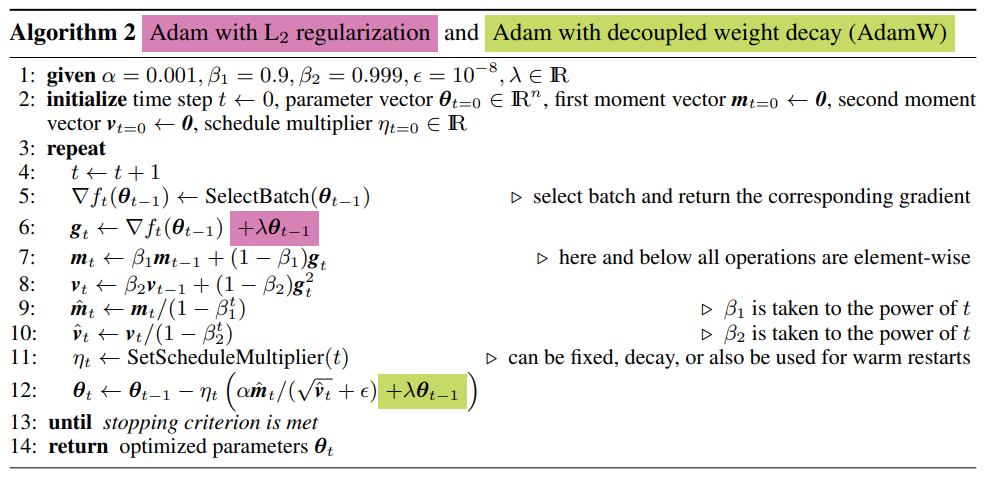

绿色部分是AdamW改动的地方，红色的部分是Adam原有的运算过程。


- **核心思想**：解耦权重衰减（L2正则化）和梯度更新。
- **改进点**：
  - 原始Adam将权重衰减混入梯度（导致衰减效果被自适应学习率削弱）。
  - AdamW显式分离权重衰减项：

$$
\theta_{t+1} = \theta_t - \gamma \left( \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} + \lambda \theta_t \right)
$$

- **特点**：
  - 提升模型泛化能力，被大模型（如LLaMA2）广泛采用。

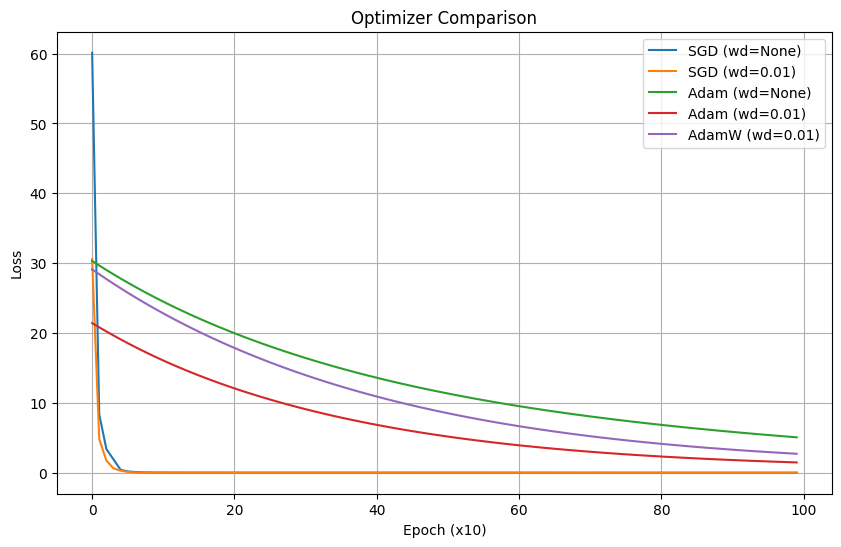

In [2]:
import torch
import matplotlib.pyplot as plt
torch.manual_seed(42)

# 定义模型和数据
out_dim = 64
input_data = torch.randn(64, out_dim)
target = torch.randn(64, 1)

def loss_function(pred, label):
    b, _ = pred.size()
    return (0.5 / b) * (pred - label).pow(2).sum()

# 优化器实现
class SGD:
    def __init__(self, params, lr=1e-3, momentum=0.9, weight_decay=None):
        self.w = params
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.velocity = torch.zeros_like(params)
    
    def step(self, grad):
        if self.weight_decay is not None:
            grad = grad + self.weight_decay * self.w
        
        self.velocity = self.momentum * self.velocity + grad
        self.w = self.w - self.lr * self.velocity
        return self.w

class Adam:
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=None):
        self.w = params
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay
        
        self.m = torch.zeros_like(params)
        self.v = torch.zeros_like(params)
        self.t = 0
    
    def step(self, grad):
        self.t += 1
        
        if self.weight_decay is not None:
            grad = grad + self.weight_decay * self.w
        
        self.m = self.beta1 * self.m + (1 - self.beta1) * grad
        self.v = self.beta2 * self.v + (1 - self.beta2) * grad.pow(2)
        
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)
        
        self.w = self.w - self.lr * m_hat / (v_hat.sqrt() + self.eps)
        return self.w

class AdamW:
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2):
        self.w = params
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay
        
        self.m = torch.zeros_like(params)
        self.v = torch.zeros_like(params)
        self.t = 0
    
    def step(self, grad):
        self.t += 1
        
        # Adam部分
        self.m = self.beta1 * self.m + (1 - self.beta1) * grad
        self.v = self.beta2 * self.v + (1 - self.beta2) * grad.pow(2)
        
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)
        
        # AdamW的解耦权重衰减
        update = m_hat / (v_hat.sqrt() + self.eps)
        if self.weight_decay is not None:
            self.w = self.w - self.lr * (update + self.weight_decay * self.w)
        else:
            self.w = self.w - self.lr * update
            
        return self.w

# 训练和对比函数
def train_and_compare(optimizer_class, optimizer_name, weight_decay=None, epochs=1000):
    w = torch.randn(out_dim, 1, requires_grad=False)
    if optimizer_name == 'AdamW':
        optimizer = optimizer_class(w, weight_decay=1e-2)
    else:
        optimizer = optimizer_class(w, weight_decay=weight_decay)
    
    losses = []
    for epoch in range(epochs):
        output = input_data @ w
        loss = loss_function(output, target)
        grad = input_data.t() @ (output - target)
        
        w = optimizer.step(grad)
        
        if epoch % 10 == 0:
            losses.append(loss.item())
    
    plt.plot(losses, label=f'{optimizer_name} (wd={weight_decay})')

# 对比实验
plt.figure(figsize=(10, 6))
train_and_compare(SGD, 'SGD', weight_decay=None)
train_and_compare(SGD, 'SGD', weight_decay=1e-2)
train_and_compare(Adam, 'Adam', weight_decay=None)
train_and_compare(Adam, 'Adam', weight_decay=1e-2)
train_and_compare(AdamW, 'AdamW', weight_decay=1e-2)

plt.xlabel('Epoch (x10)')
plt.ylabel('Loss')
plt.title('Optimizer Comparison')
plt.legend()
plt.grid(True)
plt.show()